# FF-VUS

## Setup

In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

experiments_path = os.path.join('..', '..', 'experiments')
save_fig_path = os.path.join(experiments_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [110]:
# Consistent color palette
color_palette = {
    'FF-VUS (L: 128)': '#c8b400',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'AFFILIATION': '#A5D1C2',        # Useless competitors
    'Range-AUC (L: 128)': '#547C6E',       # Useless competitors
    'RF': '#123327',                    # Useless competitors
}

# Map shorthand names to formal names
formal_names = {
    'FF-VUS': 'FF-VUS (L: 128)',
    'FF-VUS-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC': 'AUC',
    'VUS': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC': 'Range-AUC (L: 128)',
}

# Default seaborn style
sns.set_style("whitegrid")

In [111]:
def finalize_plot(save_dir, filename):
    plt.tight_layout()
    if filename is not None:
        save_path = os.path.join(save_dir, filename)
        # plt.savefig(f"{save_path}.svg", bbox_inches='tight')
        plt.savefig(f"{save_path}.pdf", bbox_inches='tight')
    plt.show()

def load_results(path):
    result_files = [file for file in os.listdir(path) if file.endswith('.csv')]

    df = pd.DataFrame()
    for file in tqdm(result_files):
        file_path = os.path.join(path, file)
        curr_df = pd.read_csv(file_path, index_col=0).reset_index()
        df = pd.concat([df, curr_df], ignore_index=True)
    return df


## Experiment 1: All metrics with default parameters on the TSB-UAD benchmark

In [112]:
curr_experiment_path = os.path.join(experiments_path, 'allmetrics_defparams_tsb', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 7/7 [00:00<00:00, 122.06it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Metric,Metric value,Metric time,Existence,Step,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
170,IOPS/KPI-1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0....,149155,56,11.303571,128.0,Range-AUC (L: 128),0.049932,0.108025,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3335,GHL/07_Lev_fault_Temp_corr_seed_31_vars_23.tes...,200000,1,144.000000,128.0,VUS (L: 128),0.009631,0.712985,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9159,NAB/NAB_data_Exchange_6.out,1641,4,40.000000,NaN,RF,0.000000,0.008026,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Runtime Box plots

In [ ]:
# Average speed-ups compared to VUS
metric_to_compare = 'VUS (L: 128)'
speed_up_dict = {}

df_vus = df[df['Metric'] == metric_to_compare].set_index('Time series')
for metric in df['Metric'].unique():
    curr_df = df[df['Metric'] == metric].set_index('Time series')

    common_index = df_vus.index.intersection(curr_df.index)
    curr_speed_up = df_vus.loc[common_index, 'Metric time'] / curr_df.loc[common_index, 'Metric time']
    speed_up_dict[metric] = curr_speed_up.mean()
    print(f"{metric}: {speed_up_dict[metric]:.2f}x speed up")

Range-AUC (L: 128): 58.31x speed up
VUS (L: 128): 1.00x speed up
AFFILIATION: 128.03x speed up
AUC: 480.69x speed up
RF: 17.24x speed up
FF-VUS (L: 128): 110.71x speed up
FF-VUS-GPU (L: 128): 467.44x speed up


In [118]:
# Error of FF-VUS and FF-VUS-GPU compared to VUS
current_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
vus_df = df[df['Metric'] == 'VUS (L: 128)'].set_index('Time series')

values_df = df[df['Metric'].isin(current_metrics)][['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.apply(lambda row: row - vus_df.loc[row.name]['Metric value'], axis=1).abs()
dif_df.head(3)

Metric,FF-VUS (L: 128),FF-VUS-GPU (L: 128)
Time series,,
Daphnet/S01R02E0.test.csv@1.out,0.0,1.677621e-08
Daphnet/S01R02E0.test.csv@4.out,0.0,7.568250e-07
Daphnet/S01R02E0.test.csv@6.out,0.0,5.137035e-08


In [ ]:
# Average time per time series
for metric in df['Metric'].unique():
    mean_per_ts = df[df['Metric'] == metric]['Metric time'].mean()

    print(f"{metric}: {mean_per_ts:.6f} seconds per ts")

Range-AUC (L: 128): 0.050070 seconds per ts
VUS (L: 128): 3.126450 seconds per ts
AFFILIATION: 0.034216 seconds per ts
AUC: 0.005249 seconds per ts
RF: 0.362132 seconds per ts
FF-VUS (L: 128): 0.037790 seconds per ts
FF-VUS-GPU (L: 128): 0.003939 seconds per ts


In [121]:
# We use it at experiment 3
df_auc = df[df['Metric'] == 'AUC']

/tmp/ipykernel_8231/3184609119.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axis.set_ylim(0, 80)


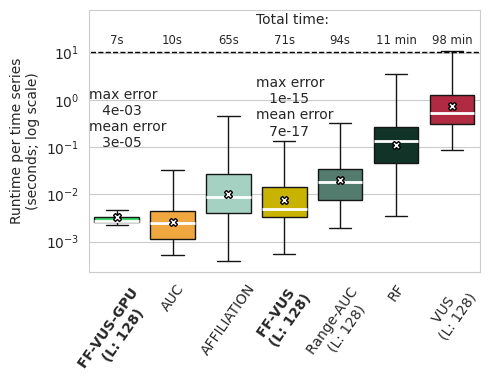

In [17]:
# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].mean()
order = median_times.sort_values().index.to_list()

fig = plt.figure(figsize=(5, 4))

medianprops = dict(linestyle='-', linewidth=2, color='white')
meanprops = dict(
    marker='X',
    markerfacecolor='white',
    markeredgecolor='black',
    markersize=6
)

axis = sns.boxplot(
    y='Metric time',
    x='Metric',
    hue='Metric',
    data=df,
    showfliers=False,
    log_scale=True,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    palette=color_palette,
    order=order,
    saturation=1,
)
axis.set_ylabel('Runtime per time series\n(seconds; log scale)')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=55)
axis.grid(visible=False, axis='x')
axis.hlines(y=10.5, xmin=-1, xmax=7, linestyle='--', lw=1, color='k')
axis.set_xlim(-0.5, 6.5)
axis.set_ylim(0, 80)
axis.text(2.5, 40, 'Total time:')

for i, metric in enumerate(order):
    if 'FF-' in metric:
        axis.annotate(
            # f'{speed_up_dict[metric]:.0f}x faster\nmax error\n{dif_df[metric].max():.0e}', 
            f'max error\n   {dif_df[metric].max():.0e}\nmean error\n   {dif_df[metric].mean():.0e}', 
            xy=(i, 10), 
            xytext=((i - .5, 0.1 + i*0.025)),
            # bbox=dict(boxstyle='square', facecolor='white', alpha=0.8),
            # arrowprops=dict(arrowstyle="->", color='k', alpha=0.5, linestyle='--')
        )
    total = df.loc[df['Metric'] == metric, 'Metric time'].sum()
    if total > 100:
        label = f'{total/60:.0f} min'
    else:
        label = f'{total:.0f}s'
    axis.text(i, 25, label, ha='center', va='top', fontsize='small')
        

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if 'FF-' in xticklabels[idx].get_text():
        xticklabels[idx].set_fontweight('bold')
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(', '\n(')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

# # Remove borders around the boxes but keep whiskers and caps
# for j, patch in enumerate(axis.patches):
#     facecolor = patch.get_facecolor()
#     if all([x == 1 for x in facecolor]):
#         patch.set_facecolor((1, 1, 1, 0.0))  # alpha = 0.0
#         patch.set_edgecolor((0, 0, 0, 1.0))  # fully opaque border
#         patch.set_linewidth(1.5)

#         axis.lines[j * 6 + 4].set_color('black')    # 6 lines per box and usually the median is the 4th
#         axis.lines[j * 6 + 4].set_linewidth(1.5)
#     else:
#         patch.set_edgecolor(facecolor)
#         patch.set_linewidth(0.5)

finalize_plot(save_fig_path, 'exec_time_comparison_tsb')

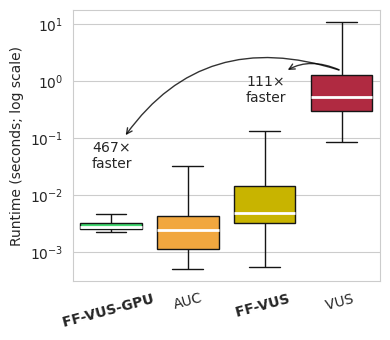

In [18]:
# What is the execution time difference
curr_df  = df[df['Metric'].isin(['AUC', 'FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'VUS (L: 128)'])]
median_times = curr_df.groupby('Metric')['Metric time'].mean()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(4, 3.5))

axis = sns.boxplot(
    y='Metric time',
    x='Metric',
    hue='Metric',
    data=curr_df,
    showfliers=False,
    log_scale=True,
    showmeans=False,
    meanprops=meanprops,
    medianprops=medianprops,
    palette=color_palette,
    order=order,
    saturation=1,
)
axis.set_ylabel('Runtime (seconds; log scale)')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=15)
axis.grid(visible=False, axis='x')

for i, metric in enumerate(order):
    if 'FF-' in metric:
        axis.annotate(
            f'{speed_up_dict[metric]:.0f}$\\times$\nfaster', 
            xy=(3, 1.5), 
            xytext=(i-0.25, 0.09 + i*0.6),
            arrowprops=dict(arrowstyle="<-", connectionstyle="arc3,rad=-.4", color='k', alpha=0.8),
            # ha='center',
            va='top'
        )

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if 'FF-' in xticklabels[idx].get_text():
        xticklabels[idx].set_fontweight('bold')
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(L: 128)', '')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

finalize_plot(save_fig_path, 'exec_time_comparison_tsb_small')

### Error boxplot

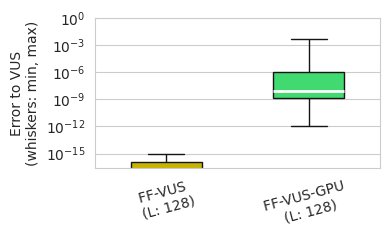

In [19]:
plt.figure(figsize=(4, 2.5))

axis = sns.boxplot(
    dif_df, 
    showfliers=False, 
    fill=True, 
    flierprops={"marker": "o"},
    medianprops=medianprops,
    width=.5, 
    palette=color_palette, 
    saturation=1,
    whis=[0, 100]
)
axis.set_ylabel('Error to VUS\n(whiskers: min, max)')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=15)
axis.grid(visible=False, axis='x')
axis.set_yscale('log')
axis.set_yticks([10**-x for x in range(0, 16)][::3])

# axis.annotate(f'Max error\n   9e-16', (0 - 0.2, 0.00005))
# axis.annotate(f'Max error\n   {dif_df['FF-VUS-GPU (L: 128)'].max():.3f}', (1 - 0.2, 0.00005))

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(', '\n(')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

finalize_plot(save_fig_path, 'ffvus_error_analysis_tsb')

## Experiment 2: All metrics with default parameters on the synthetic datasets

In [20]:
curr_experiment_path = os.path.join(experiments_path, 'allmetrics_defparams_syn', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 70/70 [00:00<00:00, 398.80it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Metric,Metric value,Metric time,Slope size,Step,Global mask,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
1411,syn_len_100000_n_900_avglen_10.npz,100000,818,10.533007,AUC,0.899640,0.011633,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
460,syn_len_100000_n_1000_avglen_10.npz,100000,920,10.441304,Range-AUC (L: 128),0.884005,0.192575,128.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1346,syn_len_100000_n_10_avglen_400.npz,100000,10,395.000000,Range-AUC (L: 128),0.818969,0.085199,128.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Time series characteristics runtime analysis

In [21]:
length_analysis_df = df[df['Length'] != 100_000]
n_anomalies_analysis_df = df[np.logical_and(df['Time series'].str.contains('len_100000_'), df['Time series'].str.contains('_avglen_10.npz'))]
avg_anomaly_length_analysis_df = df[df['Time series'].str.contains('len_100000_n_10_')]

avg_anomaly_length_analysis_df.loc[:, 'Anomalies average length'] = avg_anomaly_length_analysis_df.apply(lambda row: int(row['Time series'].split('_')[-1].replace('.npz', '')), axis=1)
n_anomalies_analysis_df.loc[:, 'Number of anomalies'] = n_anomalies_analysis_df.apply(lambda row: int(row['Time series'].split('_')[-3]), axis=1)

analysis_dfs = [
    length_analysis_df, 
    n_anomalies_analysis_df, 
    avg_anomaly_length_analysis_df
]
attributes = ["Length", "Number of anomalies", "Anomalies average length"]

/home/sylli/anaconda3/envs/ffvus/lib/python3.12/site-packages/matplotlib/scale.py:270: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)
/tmp/ipykernel_8231/2316073209.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


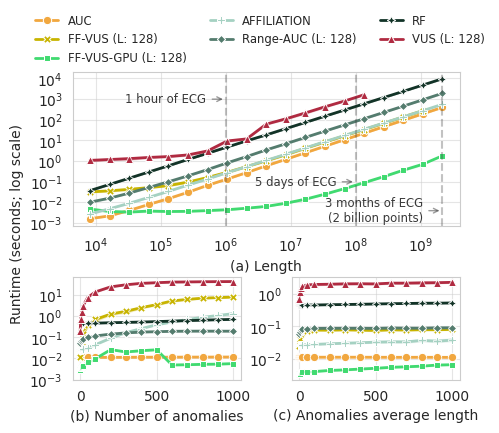

In [31]:
fig = plt.figure(figsize=(5, 4))
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 2], wspace=0.3, hspace=0.4)
attr_axis = {
    "Length": gs[0, :],
    "Number of anomalies": gs[1, 0],
    "Anomalies average length": gs[1, 1],
}
abc_numbered = {0: 'a', 1: 'b', 2: 'c'}

legend_axis = None
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(attr_axis[attribute])
    curr_df = analysis_dfs[i]

    sns.lineplot(
        x=attribute,
        y='Metric time',
        hue='Metric',
        data=curr_df,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes=False,
        linewidth=2,
        zorder=1,
        estimator=np.median
    )
    axis.set_yscale('log')
    axis.grid(axis='both', alpha=0.5)
    axis.set_xlabel(f"({abc_numbered[i]}) {attribute}")
    axis.set_ylabel('')

    if attribute == "Length":
        axis.set_xscale('log', base=10)
    if i != 0:
        axis.get_legend().remove()
        if i == 1:
            axis.set_yticks([0.001, 0.01, 0.1, 1, 10])    
    else:
        legend_axis = axis

        axis.set_yticks([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])

        # 1 million points (~1 hour of ECG)
        x_val = 1e6
        y_val = 1000
        curr_color = "#383838"
        axis.annotate("1 hour of ECG",
                    xy=(x_val, y_val), xytext=(x_val / 2, y_val),
                    ha='right', va='center', fontsize='small', color=curr_color,
                    arrowprops=dict(arrowstyle="->", color=curr_color, alpha=0.5))
        axis.axvline(x=x_val, ymin=0, ymax=20000, color=curr_color, linestyle='--', alpha=0.3)

        # 100 million points (~5 days of ECG)
        x_val = 1e8
        y_val = 0.1
        axis.annotate("5 days of ECG",
                    xy=(x_val, y_val), xytext=(x_val / 2, y_val),
                    ha='right', va='center', fontsize='small', color=curr_color,
                    arrowprops=dict(arrowstyle="->", color=curr_color, alpha=0.5))
        axis.axvline(x=x_val, ymin=0, ymax=20000, color=curr_color, linestyle='--', alpha=0.3)

        # 1 billion points (~3 months of ECG)
        x_val = 2**31
        y_val = 0.004
        axis.annotate("3 months of ECG\n(2 billion points)",
                    xy=(x_val, y_val), xytext=(x_val / 2, y_val),
                    ha='right', va='center', fontsize='small', color=curr_color,
                    arrowprops=dict(arrowstyle="->", color=curr_color, alpha=0.5))
        axis.axvline(x=x_val, ymin=0, ymax=20000, color=curr_color, linestyle='--', alpha=0.3)

fig.text(
    0, 0.5,
    "Runtime (seconds; log scale)",
    va='center',
    rotation='vertical',
)

if legend_axis:
    handles, labels = legend_axis.get_legend_handles_labels()
    legend_axis.get_legend().remove()
    fig.legend(
        handles,
        labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=(len(labels)//2),
        # nrow=2,
        frameon=False,
        fontsize='small'
    )
finalize_plot(save_fig_path, 'exec_time_per_ts_char_syn')

### Computation step runtime analysis

In [40]:
rename_dict = {
    'Anomaly coordinates time': 'Anom.\ncoords',
    'Safe mask time': 'Mask',
    'Thresholds time': 'Thresh.',
    'Score mask time': 'Scores',
    'Position time': 'Pos.',
    'Slopes time': 'Buffers',
    'Existence time': 'Existence',
    'Confusion matrix time': 'Conf. mat.',
    'Precision recall curve time': 'PR curve',
    'Integral time': 'Integral',
}
rename_dict = {k: f'({chr(i + 97)}) {v}' for i, (k, v) in enumerate(rename_dict.items())}

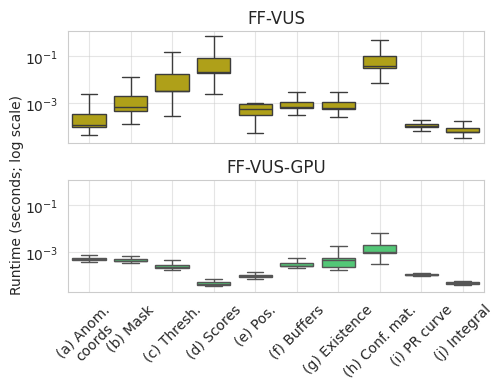

In [41]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
curr_df = df[df['Metric'].isin(metrics)]

fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharey=True)
for i, col in enumerate(time_analysis_cols):
    for j, axis in enumerate(ax):
        sns.boxplot(
            curr_df[curr_df['Metric'] == metrics[j]], 
            ax=axis, 
            x=i, 
            y=col, 
            log_scale=True, 
            legend=(i == 0), 
            color=color_palette[metrics[j]], 
            showfliers=False
        )
        if j != 0:
            axis.set_xticks(np.arange(len(time_analysis_cols)), [rename_dict[x] for x in time_analysis_cols])
        else:
            axis.set_xticks(np.arange(len(time_analysis_cols)), [])

        axis.set_title(metrics[j].replace(' (L: 128)', ''))
        axis.set_ylabel('')
        axis.set_xlabel('')
        axis.tick_params(axis='x', rotation=45)
        axis.grid(axis='both', alpha=0.5)

fig.text(
    0, 0.5,
    "Runtime (seconds; log scale)",
    va='center',
    rotation='vertical',
)

finalize_plot(save_fig_path, 'per_part_runtime_syn')

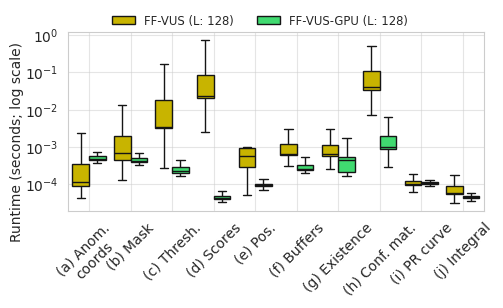

In [42]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
curr_df = df[df['Metric'].isin(metrics)]

fig, axis = plt.subplots(1, 1, figsize=(5, 3))
for i, col in enumerate(time_analysis_cols):
    sns.boxplot(
        curr_df, 
        ax=axis, 
        x=i, 
        y=col, 
        log_scale=True, 
        legend=(i == 0), 
        hue='Metric',
        palette=color_palette, 
        showfliers=False,
        saturation=1
    )
    if j != 0:
        axis.set_xticks(np.arange(len(time_analysis_cols)), [rename_dict[x] for x in time_analysis_cols])
    else:
        axis.set_xticks(np.arange(len(time_analysis_cols)), [])

    axis.set_title('')
    axis.set_ylabel('')
    axis.set_xlabel('')
    axis.tick_params(axis='x', rotation=45)
    axis.grid(axis='both', alpha=0.5)
    axis.legend()

fig.text(
    0, 0.57,
    "Runtime (seconds; log scale)",
    va='center',
    rotation='vertical',
)

handles, labels = axis.get_legend_handles_labels()
axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.03),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'per_part_runtime_syn')

## Experiment 3: VUS / Buffer & Step comparison / TSB

### Buffer comparison

In [124]:
curr_experiment_path = os.path.join(experiments_path, 'vus_buffer_comparison_tsb', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 30/30 [00:00<00:00, 97.59it/s] 


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time
47855,OPPORTUNITY/S1-ADL2.test.csv@76.out,31891,2,697.500000,512,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS (L: 128),0.342107,1.672981
36933,YAHOO/Yahoo_A2synthetic_85_data.out,1420,2,2.000000,0,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS (L: 128),0.002250,0.004074
34055,ECG/MBA_ECG14046_data_3.out,229899,561,93.912656,0,1.0,True,function,True,dynamic_plus,...,0.000041,0.000542,0.00061,0.000192,0.000442,0.000101,0.000041,FF-VUS-GPU (L: 128),0.725636,0.003889


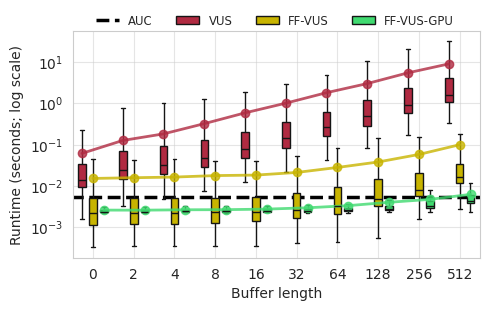

In [149]:
order = ['VUS (L: 128)', 'FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']

fig, axis = plt.subplots(1, 1, figsize=(5, 3))

# First create the boxplot
axis.hlines(y=df_auc['Metric time'].mean(), xmin=-1, xmax=10, linestyle='--', lw=2.5, color='k', label='AUC')
sns.boxplot(
    ax=axis,
    y='Metric time', 
    x='Slope size', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    saturation=1,
    gap=.3,
    hue_order=order
)


# Add lines connecting means for each metric
for i, metric in enumerate(order):
    means = df[df['Metric'] == metric].groupby('Slope size')['Metric time'].mean()
    axis.plot(np.arange(len(means)) + (i - 1) * 0.27, means, '-o', lw=2, label=f'{metric} mean', alpha=0.8, color=color_palette[metric])

plt.xlabel('Buffer length')
plt.ylabel('Runtime (seconds; log scale)')
plt.grid(axis='both', alpha=0.5)
axis.set_xlim(-0.5, 9.5)

handles, labels = axis.get_legend_handles_labels()
labels = [label.replace(' (L: 128)', '').replace(' mean', '') for label in labels[:4]]
axis.get_legend().remove()
fig.legend(
    handles[:4],
    labels,
    loc='upper center',
    bbox_to_anchor=(0.56, 1.04),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'exec_time_buffer_comparison')

### Step comparison

In [102]:
curr_experiment_path = os.path.join(experiments_path, 'vus_step_comparison_tsb', 'results')
df_step = load_results(curr_experiment_path)    
df_step['Metric'] = df_step['Metric'].map(formal_names)
df_step.sample(3)

100%|██████████| 20/20 [00:00<00:00, 76.90it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time
1318,YAHOO/YahooA4Benchmark-TS9_data.out,1679,1,1.0,512,32,True,precomputed,optimized,dynamic_plus,...,0.000082,0.000071,0.000050,0.000079,0.000458,0.000033,0.000025,FF-VUS (L: 128),0.896309,0.000998
3335,GHL/07_Lev_fault_Temp_corr_seed_31_vars_23.tes...,200000,1,144.0,512,2,True,function,True,dynamic_plus,...,0.000038,0.000081,0.000222,0.000187,0.000796,0.000103,0.000044,FF-VUS-GPU (L: 128),0.011182,0.003274
999,YAHOO/YahooA3Benchmark-TS75_data.out,1679,14,1.0,512,32,True,precomputed,optimized,dynamic_plus,...,0.000102,0.000171,0.000372,0.000720,0.001157,0.000045,0.000027,FF-VUS (L: 128),0.928339,0.002772


In [103]:
df_vus_512 = df[np.logical_and(df['Metric'] == 'VUS (L: 128)', df['Slope size'] == 512)]

In [104]:
df_vus_512_control = df_vus_512.set_index('Time series')['Metric value']

df_step['Error'] = df_step.apply(lambda row: row['Metric value'] - df_vus_512_control.loc[row['Time series']], axis=1)
df_step.sample(3)

,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time,Error
29031,SMD/machine-3-7.test.csv@30.out,28704,5,86.800000,512,4,True,precomputed,optimized,dynamic_plus,...,0.000522,0.001527,0.000728,0.006812,0.000108,0.000072,FF-VUS (L: 128),0.103020,0.012238,9.217496e-05
1916,Daphnet/S01R02E0.test.csv@6.out,28799,5,309.400000,512,2,True,function,True,dynamic_plus,...,0.000070,0.000200,0.000163,0.003404,0.000092,0.000036,FF-VUS-GPU (L: 128),0.077314,0.005594,-3.963480e-08
26033,SVDB/869.test.csv@1.out,230399,535,143.327103,512,128,True,function,True,dynamic_plus,...,0.000080,0.002598,0.000201,0.003359,0.000096,0.000037,FF-VUS-GPU (L: 128),0.879016,0.008178,-1.980327e-02


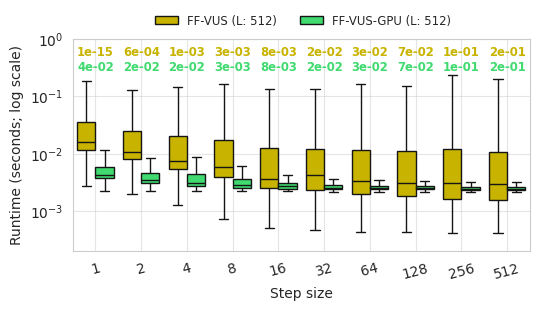

In [108]:
fig, axis = plt.subplots(1, 1, figsize=(5.5, 3))
# plt.hlines(df_vus_512['Metric time'].mean(), xmin=-1, xmax=512, lw=2.5, color=color_palette['VUS (L: 128)'], linestyle='--', label='VUS (L: 512)')
sns.boxplot(
    y='Metric time', 
    x='Step', 
    data=df_step, 
    showfliers=False, 
    log_scale=True,
    hue='Metric',
    palette=color_palette,
    saturation=1,
    ax=axis
)
axis.set_xlabel('Step size')
axis.set_ylabel('Runtime (seconds; log scale)')
axis.tick_params(axis='x', labelrotation=15)
axis.grid(axis='both', alpha=0.5)
axis.set_ylim(0.0002, 1)

# annotate error info above each Step box
steps = sorted(df_step['Step'].dropna().unique())
for i, s in enumerate(steps):
    errs = df_step.loc[df_step['Step'] == s, 'Error'].abs()
    
    for j, metric in enumerate(metrics[::-1]):
        axis.text(i, 
            .25 + j*0.2, 
            f'{df_step[np.logical_and(df_step['Metric'] == metric, df_step['Step'] == s)]['Error'].max():.0e}', 
            ha='center', 
            va='bottom', 
            fontsize='small',
            color=color_palette[metric],
            weight='bold',
            # bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
        )

handles, labels = axis.get_legend_handles_labels()
labels = [label.replace(' (L: 128)', ' (L: 512)') for label in labels]
axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.56, 1.04),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'step_comparison')

/home/sylli/anaconda3/envs/ffvus/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


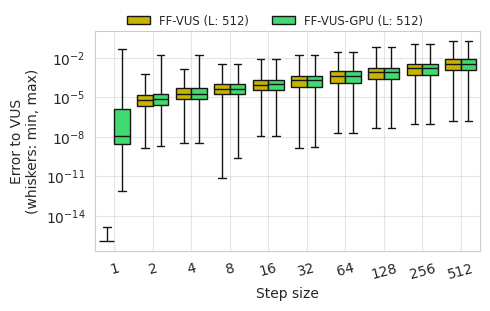

In [219]:
fig, axis = plt.subplots(1, 1, figsize=(5, 3))    
sns.boxplot(
    y='Error', 
    x='Step', 
    data=df_step, 
    showfliers=False, 
    log_scale=True,
    hue='Metric',
    palette=color_palette,
    saturation=1,
    ax=axis,
    whis=[0, 100]
)
axis.set_xlabel('Step size')
axis.set_ylabel('Error to VUS\n(whiskers: min, max)')
axis.tick_params(axis='x', labelrotation=15)
# axis.set_yticks([10**i for i in range(-3, 4)])
axis.grid(axis='both', alpha=0.5)

handles, labels = axis.get_legend_handles_labels()
labels = [label.replace(' (L: 128)', ' (L: 512)') for label in labels]
axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.56, 1.04),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'error_step_comparison')

## Experiment 4: Equivalence to AUC

In [ ]:
curr_experiment_path = os.path.join(experiments_path, 'vus_ffvus_auc_0_tsb', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 4/4 [00:00<00:00, 109.64it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time
4269,OPPORTUNITY/S1-ADL5.test.csv@90.out,30047,2,609.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUC,0.107421,0.002552
5826,IOPS/KPI-c69a50cf-ee03-3bd7-831e-407d36c7ee91....,149158,59,11.898305,0.0,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS (L: 128),0.004193,0.108525
6425,SMD/machine-2-4.test.csv@19.out,23688,20,84.700000,0.0,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS (L: 128),0.112668,0.024168


In [232]:
values_df = df[['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.copy()
for metric in metrics: 
    dif_df[metric] = values_df[metric] - values_df['AUC']

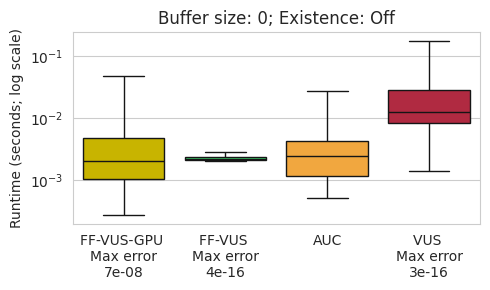

In [234]:
metrics = df['Metric'].unique()
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

fig, axis = plt.subplots(1, 1, figsize=(5, 3))
sns.boxplot(
    y='Metric time', 
    x='Metric', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    order=order, 
    ax=axis,
    saturation=1
)
axis.set_xlabel('')
axis.set_ylabel('Runtime (seconds; log scale)')
axis.set_title('Buffer size: 0; Existence: Off')
axis.set_xticks(np.arange(len(metrics)), [x.replace('(L: 128)', f'\nMax error\n{dif_df.max()[x]:.0e}') for x in metrics])

finalize_plot(save_fig_path, 'exec_time_auc_equivalence')

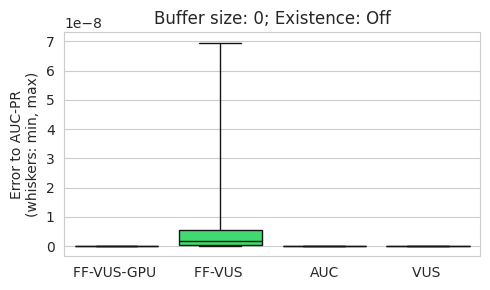

In [230]:
fig, axis = plt.subplots(1, 1, figsize=(5, 3))

sns.boxplot(
    dif_df.abs(), 
    showfliers=True, 
    palette=color_palette, 
    order=order, 
    log_scale=False, 
    ax=axis,
    saturation=1,
    whis=[0, 100]
)
axis.set_xlabel('')
axis.set_ylabel('Error to AUC-PR\n(whiskers: min, max)')
axis.set_title('Buffer size: 0; Existence: Off')
axis.set_xticks(np.arange(len(metrics)), [x.replace('(L: 128)', '(L: 0, E: Off)') for x in metrics])
axis.set_xticks(np.arange(len(metrics)), [x.replace('(L: 128)', '') for x in metrics])

finalize_plot(save_fig_path, 'error_auc_equivalence')